# Overview

In this example, we are going to conduct high-throughput virtual screening on the WDR domain of LRRK2 protein.

As an example, we only use a subset (10,000 entries) of the Mcule library. It could be any library (for examples ZINC, Enamine, etc.) as long as it contains the smiles information.


In [1]:
tankbind_src_folder_path = "../tankbind/"
import sys
sys.path.insert(0, tankbind_src_folder_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import gvp
import gvp.data
import torch

In [2]:
import torch
a = torch.arange(1,17).reshape(4,4).unsqueeze(-1)
b = torch.arange(1,17).reshape(4,4).unsqueeze(-1)
c = torch.einsum("bik,bjk->bijk", a, b)[0]

In [21]:
import torch
import torch.nn as nn
import math

entroy=nn.CrossEntropyLoss()
input=torch.Tensor([[-0.7715, -0.6205,-0.2562]])
target = torch.tensor([0])
output = entroy(input, target)
output

tensor(1.3447)

In [2]:
# protein name, compounds name, smiles name.

pdb_name = "6scm"  
cp_name = "SOS1"

# csv_name with .csv
csv_name = "SOS1-ID-SMILES.csv"
right_pocket = "pocket_4"


distinguish_by_timestamp = True

In [3]:
base_pre = f"./NCIVS/"
timetag = time.strftime("%m%d%H%M")

if distinguish_by_timestamp:
    pre = f"{base_pre}/{cp_name}-{pdb_name}-{timetag}"
else:
    pre = f"{base_pre}/{cp_name}-{pdb_name}"

os.system(f"mkdir -p {pre}")
os.system(f"rm -rf {pre}/sdfs")
os.system(f"mkdir -p {pre}/sdfs")
os.system(f"rm -rf {pre}/PDBs")
os.system(f"mkdir -p {pre}/PDBs")
os.system(f"rm -rf {pre}/p2rank")
os.system(f"mkdir -p {pre}/p2rank")
os.system(f"cp ./inputs/{csv_name} {pre}")
os.system(f"cp ./inputs/{pdb_name}.pdb {pre}")

proteinName = pdb_name
proteinFile = f"{pre}/{proteinName}.pdb"

# get protein feature

In [4]:
from feature_utils import get_protein_feature

In [5]:
from Bio.PDB import PDBParser
from feature_utils import get_clean_res_list
parser = PDBParser(QUIET=True)
protein_dict = {}
proteinName = pdb_name
proteinFile = f"{pre}/{proteinName}.pdb"
s = parser.get_structure("example", proteinFile)
res_list = list(s.get_residues())
clean_res_list = get_clean_res_list(res_list, ensure_ca_exist=True)  ##保证['CA']在残基内部

In [6]:
three_to_one = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 
                'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 
                'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

In [7]:
res_list = [res for res in clean_res_list if (('N' in res) and ('CA' in res) and ('C' in res) and ('O' in res))]
# construct the input for ProteinGraphDataset
# which requires name, seq, and a list of shape N * 4 * 3
structure = {}
structure['name'] = "placeholder"
structure['seq'] = "".join([three_to_one.get(res.resname) for res in res_list])
coords = []
for res in res_list:
    res_coords = []
    for atom in [res['N'], res['CA'], res['C'], res['O']]:
        res_coords.append(list(atom.coord))
    coords.append(res_coords)
    # print(coords)
structure['coords'] = coords
torch.set_num_threads(1)        # this reduce the overhead, and speed up the process for me.
dataset = gvp.data.ProteinGraphDataset([structure])
protein = dataset[0]
x = (protein.x, protein.seq, protein.node_s, protein.node_v, protein.edge_index, protein.edge_s, protein.edge_v)

In [10]:
protein = structure

In [11]:
import torch_cluster
device = 'cpu'
top_k = 30
def _positional_embeddings(edge_index, 
                               num_embeddings=None,
                               period_range=[2, 1000]):
        # From https://github.com/jingraham/neurips19-graph-protein-design
        num_embeddings = num_embeddings or 16
        d = edge_index[0] - edge_index[1]
        frequency = torch.exp(
            torch.arange(0, num_embeddings, 2, dtype=torch.float32, device=device)
            * -(np.log(10000.0) / num_embeddings)
        )
        angles = d.unsqueeze(-1) * frequency
        E = torch.cat((torch.cos(angles), torch.sin(angles)), -1)
        return E
    
letter_to_num = {'C': 4, 'D': 3, 'S': 15, 'Q': 5, 'K': 11, 'I': 9,
                       'P': 14, 'T': 16, 'F': 13, 'A': 0, 'G': 7, 'H': 8,
                       'E': 6, 'L': 10, 'R': 1, 'W': 17, 'V': 19, 
                       'N': 2, 'Y': 18, 'M': 12}
with torch.no_grad():
    coords = torch.as_tensor(protein['coords'], 
                             device=device, dtype=torch.float32)   
    seq = torch.as_tensor([letter_to_num[a] for a in protein['seq']],
                          device=device, dtype=torch.long)

    mask = torch.isfinite(coords.sum(dim=(1,2)))
    coords[~mask] = np.inf

    X_ca = coords[:, 1]
    edge_index = torch_cluster.knn_graph(X_ca, k=top_k)

    pos_embeddings = _positional_embeddings(edge_index)
    E_vectors = X_ca[edge_index[0]] - X_ca[edge_index[1]]
    

In [13]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
batch = torch.tensor([0, 0, 0, 0])
edge_index = torch_cluster.knn_graph(x, k=2, batch=batch, loop=False)
edge_index

tensor([[1, 2, 0, 3, 0, 3, 1, 2],
        [0, 0, 1, 1, 2, 2, 3, 3]])

In [15]:
pos_embeddings.shape

torch.Size([14070, 16])

In [16]:
def _normalize(tensor, dim=-1):
    '''
    Normalizes a `torch.Tensor` along dimension `dim` without `nan`s.
    '''
    return torch.nan_to_num(
        torch.div(tensor, torch.norm(tensor, dim=dim, keepdim=True)))
X= coords
eps=1e-7
import torch.nn.functional as F
X = torch.reshape(X[:, :3], [3*X.shape[0], 3])
X.shape
dX = X[1:] - X[:-1]

U = _normalize(dX, dim=-1)
u_2 = U[:-2]
u_1 = U[1:-1]
u_0 = U[2:]

# Backbone normals
n_2 = _normalize(torch.cross(u_2, u_1), dim=-1)
n_1 = _normalize(torch.cross(u_1, u_0), dim=-1)

# Angle between normals
cosD = torch.sum(n_2 * n_1, -1)
cosD = torch.clamp(cosD, -1 + eps, 1 - eps)
D = torch.sign(torch.sum(u_2 * n_1, -1)) * torch.acos(cosD)

# This scheme will remove phi[0], psi[-1], omega[-1]
D = F.pad(D, [1, 2]) 
D = torch.reshape(D, [-1, 3])
# Lift angle representations to the circle
D_features = torch.cat([torch.cos(D), torch.sin(D)], 1)
D_features[0]

tensor([ 1.0000,  0.6533, -0.9938,  0.0000,  0.7571, -0.1115])

In [22]:
edge_index[:30]

tensor([[  1,   2,   3,  ..., 282, 193, 461],
        [  0,   0,   0,  ..., 468, 468, 468]])

In [20]:
print(E_vectors)
print(E_vectors.norm(dim=-1))

tensor([[  0.7020,  -3.3500,  -1.7770],
        [  4.4240,  -3.2170,  -2.8070],
        [  6.9100,  -3.3370,   0.1100],
        ...,
        [  4.6020,   7.6060, -12.6750],
        [ 15.0980,   0.0630,   3.7780],
        [  7.4360,  -4.1000, -13.2740]])
tensor([ 3.8566,  6.1482,  7.6744,  ..., 15.4818, 15.5636, 15.7576])


In [17]:
def _rbf(D, D_min=0., D_max=20., D_count=16, device='cpu'):
    '''
    From https://github.com/jingraham/neurips19-graph-protein-design
    
    Returns an RBF embedding of `torch.Tensor` `D` along a new axis=-1.
    That is, if `D` has shape [...dims], then the returned tensor will have
    shape [...dims, D_count].
    '''
    D_mu = torch.linspace(D_min, D_max, D_count, device=device)
    D_mu = D_mu.view([1, -1])
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)

    RBF = torch.exp(-((D_expand - D_mu) / D_sigma) ** 2)
    return RBF
rbf = _rbf(E_vectors.norm(dim=-1), D_count=16, device=device)
rbf.shape

torch.Size([14070, 16])

In [9]:
protein_dict[proteinName] = get_protein_feature(clean_res_list)

In [59]:
protein_dict[proteinName][3].shape

torch.Size([469, 3, 3])

In [39]:
x = protein_dict[proteinName][0]
n = 0
for i in range(len(x)):
    sum = (float(x[i][0]) - 8.709) **2 + (float(x[i][1]) + 24.923) **2 + (float(x[i][2]) + 34.936) **2
    if sum <= 400:
        n += 1
n

145

# p2rank to segment the protein

In [19]:
ds = f"{pre}/protein_list.ds"
with open(ds, "w") as out:
    out.write(f"/{proteinName}.pdb\n")

In [20]:
p2rank = "bash ./p2rank_2.3/prank"
cmd = f"{p2rank} predict {ds} -o {pre}/p2rank -threads 1"
os.system(cmd)

----------------------------------------------------------------------------------------------
 P2Rank 2.3
----------------------------------------------------------------------------------------------

predicting pockets for proteins from dataset [protein_list.ds]
processing [6scm.pdb] (1/1)
predicting pockets finished in 0 hours 0 minutes 11.828 seconds
results saved to directory [/home/jovyan/TankBind/examples/NCIVS/SOS1-6scm-08080536/p2rank]

----------------------------------------------------------------------------------------------
 finished successfully in 0 hours 0 minutes 13.557 seconds
----------------------------------------------------------------------------------------------


0

In [17]:
d = pd.read_csv(f"{pre}/{csv_name}")

In [9]:
d

,Unnamed: 0,smiles,md5
0,0,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,0
1,1,C[C@@H](NC(=O)c1cc(N2CCN(C)CC2)nc2cn[nH]c12)c1...,1
2,2,CC(=O)N1C2CCC1CN(c1cc(C(=O)N[C@H](C)c3cccc(C(F...,2
3,3,CC(NC(=O)c1cc(N2CCN(C(=O)C3COC3)CC2)nc2cc[nH]c...,3
4,4,C[C@@H](NC(=O)c1cc(N2CCN(C)CC2)nc2cn[nH]c12)c1...,4
...,...,...,...
874,874,Cc1nnc(NC(C)c2cc(N)cc(C(F)(F)F)n2)c2cc(N3CC4(C...,874
875,875,Cc1nnc(NC(C)c2cc(N)cc(C(F)(F)F)n2)c2cc(N3CC(C)...,875
876,876,Cc1cc(F)ccc1C(C)Nc1nnc(C)c2cnc(N3CC(C)(O)C3)cc12,876
877,877,Cc1nnc(NC(C)c2cc(N)cc(C(F)(F)F)n2)c2cc(N3CC(C)...,877


In [21]:
info = []
for i, line in tqdm(d.iterrows(), total=d.shape[0]):
    smiles = line['smiles']
    compound_name = ""
    protein_name = proteinName
    # use protein center as the pocket center.
#    com = ",".join([str(a.round(3)) for a in protein_dict[proteinName][0].mean(axis=0).numpy()])
 #   info.append([protein_name, compound_name, smiles, "protein_center", com])
    # since WDR is actually small enough, and we are interested in finding a ligand binds to the central cavity.
    # the block centered at the centroid of the protein is enough.
    # we don't need additional p2rank predicted centers.
    if True:
        p2rankFile = f"{pre}/p2rank/{proteinName}.pdb_predictions.csv"
        pocket = pd.read_csv(p2rankFile)
        pocket.columns = pocket.columns.str.strip()
        pocket_coms = pocket[['center_x', 'center_y', 'center_z']].values
        for ith_pocket, com in enumerate(pocket_coms):
            com = ",".join([str(a.round(3)) for a in com])
            info.append([protein_name, compound_name, smiles, f"pocket_{ith_pocket+1}", com])
info = pd.DataFrame(info, columns=['protein_name', 'compound_name', 'smiles', 'pocket_name', 'pocket_com'])
info

100%|██████████| 879/879 [00:03<00:00, 287.57it/s]


,protein_name,compound_name,smiles,pocket_name,pocket_com
0,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,pocket_1,"8.709,-24.923,-34.936"
1,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,pocket_2,"14.982,-43.708,-30.367"
2,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,pocket_3,"4.658,-7.672,-15.484"
3,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,pocket_4,"1.534,-35.549,-43.763"
4,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,pocket_5,"7.982,19.069,-15.421"
...,...,...,...,...,...
7906,6scm,,Cc1nnc(NC(C)c2cc(F)cc(C#N)c2F)c2cc(N3CC(C)(N(C...,pocket_5,"7.982,19.069,-15.421"
7907,6scm,,Cc1nnc(NC(C)c2cc(F)cc(C#N)c2F)c2cc(N3CC(C)(N(C...,pocket_6,"-1.262,-16.002,-29.16"
7908,6scm,,Cc1nnc(NC(C)c2cc(F)cc(C#N)c2F)c2cc(N3CC(C)(N(C...,pocket_7,"3.006,3.753,-22.598"
7909,6scm,,Cc1nnc(NC(C)c2cc(F)cc(C#N)c2F)c2cc(N3CC(C)(N(C...,pocket_8,"15.256,-6.178,-31.047"


In [22]:
len(info['pocket_name'].unique())

9

# construct dataset

In [23]:
import torch
torch.set_num_threads(1)

In [24]:
from torch_geometric.data import Dataset
from utils import construct_data_from_graph_gvp
import rdkit.Chem as Chem    # conda install rdkit -c rdkit if import failure.
from feature_utils import extract_torchdrug_feature_from_mol, get_canonical_smiles

In [25]:
savelist = []

In [26]:
class MyDataset_VS(Dataset):
    def __init__(self, root, data=None, protein_dict=None, proteinMode=0, compoundMode=1,
                pocket_radius=20, shake_nodes=None,
                 transform=None, pre_transform=None, pre_filter=None):
        self.data = data
        self.protein_dict = protein_dict
        super().__init__(root, transform, pre_transform, pre_filter)
        print(self.processed_paths)
        self.data = torch.load(self.processed_paths[0])
        self.protein_dict = torch.load(self.processed_paths[1])
        self.proteinMode = proteinMode
        self.pocket_radius = pocket_radius
        self.compoundMode = compoundMode
        self.shake_nodes = shake_nodes
        #self.printflag = True
    @property
    def processed_file_names(self):
        return ['data.pt', 'protein.pt']

    def process(self):
        torch.save(self.data, self.processed_paths[0])
        torch.save(self.protein_dict, self.processed_paths[1])

    def len(self):
        return len(self.data)

    def get(self, idx):
        line = self.data.iloc[idx]
        smiles = line['smiles']
        pocket_com = line['pocket_com']
        pocket_com = np.array(pocket_com.split(",")).astype(float) if type(pocket_com) == str else pocket_com
        pocket_com = pocket_com.reshape((1, 3))
        use_whole_protein = line['use_whole_protein'] if "use_whole_protein" in line.index else False

        protein_name = line['protein_name']
        protein_node_xyz, protein_seq, protein_node_s, protein_node_v, protein_edge_index, protein_edge_s, protein_edge_v = self.protein_dict[protein_name]

        
        
        try:
            smiles = get_canonical_smiles(smiles)
            mol = Chem.MolFromSmiles(smiles)
            mol.Compute2DCoords()
                
            coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list, pair_dis_distribution = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)
        except:
            print("something wrong with ", smiles, "to prevent this stops our screening, we repalce it with a placeholder smiles 'CCC'")
            smiles = 'CCC'
            mol = Chem.MolFromSmiles(smiles)
            mol.Compute2DCoords()
            coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list, pair_dis_distribution = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)
        # y is distance map, instead of contact map.
        data, input_node_list, keepNode = construct_data_from_graph_gvp(protein_node_xyz, protein_seq, protein_node_s, 
                              protein_node_v, protein_edge_index, protein_edge_s, protein_edge_v,
                              coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list,
                              pocket_radius=self.pocket_radius, use_whole_protein=use_whole_protein, includeDisMap=True,
                              use_compound_com_as_pocket=False, chosen_pocket_com=pocket_com, compoundMode=self.compoundMode)
        data.compound_pair = pair_dis_distribution.reshape(-1, 16)
        #print("=================== GET RETURN =======================")
        #print(data)
        return data


In [27]:
dataset_path = f"{base_pre}/dataset/"
os.system(f"rm -r {dataset_path}")
os.system(f"mkdir -p {dataset_path}")
dataset = MyDataset_VS(dataset_path, data=info, protein_dict=protein_dict)

['NCIVS/dataset/processed/data.pt', 'NCIVS/dataset/processed/protein.pt']


Processing...
Done!


In [51]:
a = dataset[0]['protein']['node_s']

In [34]:
dataset[9]

HeteroData(
  dis_map=[4495],
  node_xyz=[145, 3],
  coords=[31, 3],
  y=[4495],
  seq=[145],
  compound_pair=[961, 16],
  protein={
    node_s=[145, 6],
    node_v=[145, 3, 3]
  },
  compound={ x=[31, 56] },
  (protein, p2p, protein)={
    edge_index=[2, 3466],
    edge_s=[3466, 32],
    edge_v=[3466, 1, 3]
  },
  (compound, c2c, compound)={
    edge_index=[2, 68],
    edge_weight=[68],
    edge_attr=[68, 19]
  }
)

In [17]:
dataset = MyDataset_VS(dataset_path)

['NCIVS/dataset/processed/data.pt', 'NCIVS/dataset/processed/protein.pt']


In [18]:
import logging
from torch_geometric.loader import DataLoader
from tqdm import tqdm    # pip install tqdm if fails.
from model import get_model

# take about 2 minutes to screen 10,000 drug candidates.

In [ ]:
import torch
from torch import nn
x = torch.randn(10,768,2)
query = nn.Linear(768*2, 2)
key = nn.Linear(768*2, 10)
ln = nn.LayerNorm(10)
x = x.view(10, 768*2)
q = query(x)
q1 = torch.softmax(q,dim=0)
x1 = key(x)
x2 = ln(x1)
x3 = torch.einsum("bi,bj->bij",q1,x2)
x4 = x3.sum(dim=2)

In [74]:
nn.Linear(10,1).to(torch.device("cuda"))

Linear(in_features=10, out_features=1, bias=True)

In [66]:
x4.shape

torch.Size([10, 2])

In [61]:
x3.shape

torch.Size([10, 10])

In [37]:
batch_size = 5 ##与口袋数相关35 35 35 36 36 32 33 33  30 37 37 33
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
# device= 'cpu'
logging.basicConfig(level=logging.INFO)
model = get_model(0, logging, device)
# modelFile = "../saved_models/re_dock.pt"
# self-dock model
modelFile = "../saved_models/self_dock.pt"
model.load_state_dict(torch.load(modelFile, map_location=device))
# for name in model.state_dict():
#     print(name, '      ')

param_list = []
name_list = []
for name, param in model.named_parameters():
    param_list.append(param)
    name_list.append(name)
print(name_list[-4:])
print(param_list[-4:])        

# _ = model.eval()

# data_loader = DataLoader(dataset, batch_size=batch_size, follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=8)
# sum_embed_t = []
# attn_embed_t = []
# affinity_pred_list = []
# y_pred_list = []
# for data in tqdm(data_loader):
#     data = data.to(device)
#     y_pred, affinity_pred, sum_embed, attn_embed = model(data)
#     affinity_pred_list.append(affinity_pred.detach().cpu())
#     sum_embed_t.append(sum_embed.detach().cpu())
#     attn_embed_t.append(attn_embed.detach().cpu())
# affinity_pred_list = torch.cat(affinity_pred_list)


model_dict = model.state_dict()
pretrainedd_dict = torch.load("../saved_models/self_dock.pt", map_location=device)
model_dict['linear_energy.weight'] = pretrainedd_dict['linear_energy.weight']
model_dict['linear_energy.bias'] = pretrainedd_dict['linear_energy.bias']
model_dict['gate_linear.weight'] = pretrainedd_dict['gate_linear.weight']
model_dict['gate_linear.bias'] = pretrainedd_dict['gate_linear.bias']
model.load_state_dict(model_dict)

05:04:18   5 stack, readout2, pred dis map add self attention and GVP embed, compound model GIN
['linear_energy.weight', 'linear_energy.bias', 'gate_linear.weight', 'gate_linear.bias']
[Parameter containing:
tensor([[-0.0040,  0.1289,  0.0683, -0.0112,  0.0831, -0.0163,  0.1378, -0.0337,
          0.0884, -0.0789,  0.0853, -0.0318,  0.0325, -0.0357,  0.0798,  0.0480,
         -0.0345,  0.0230, -0.0421, -0.0633, -0.0575,  0.0048,  0.0080, -0.0325,
         -0.0593, -0.0099,  0.0327,  0.0053,  0.0437, -0.0489,  0.0675, -0.0024,
         -0.0436, -0.0767, -0.0528,  0.0124,  0.0198, -0.0500,  0.0678,  0.0362,
          0.0046, -0.0102,  0.0195, -0.0837,  0.0411,  0.0836,  0.0044,  0.0264,
         -0.0869,  0.0062,  0.0659,  0.0683, -0.0522,  0.0926, -0.0788,  0.0338,
         -0.0016,  0.0123, -0.0597, -0.0259,  0.0203,  0.0247,  0.0345, -0.0873,
         -0.0010, -0.0810, -0.0461,  0.0626,  0.0212, -0.0468,  0.0619,  0.0410,
          0.0355, -0.0153,  0.0620, -0.0129,  0.0420,  0.0675, 

In [40]:
param_list[-2].shape

torch.Size([1, 128])

In [20]:
info = dataset.data
info['affinity'] = affinity_pred_list
chosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen

,index,protein_name,compound_name,smiles,pocket_name,pocket_com,affinity
0,3,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C(=O)C3CC3)CC2)nc2cc[...,pocket_4,"1.534,-35.549,-43.763",6.471038
1,12,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C)CC2)nc2cn[nH]c12)c1...,pocket_4,"1.534,-35.549,-43.763",6.071306
2,21,6scm,,CC(=O)N1C2CCC1CN(c1cc(C(=O)N[C@H](C)c3cccc(C(F...,pocket_4,"1.534,-35.549,-43.763",6.444242
3,30,6scm,,CC(NC(=O)c1cc(N2CCN(C(=O)C3COC3)CC2)nc2cc[nH]c...,pocket_4,"1.534,-35.549,-43.763",6.428270
4,39,6scm,,C[C@@H](NC(=O)c1cc(N2CCN(C)CC2)nc2cn[nH]c12)c1...,pocket_4,"1.534,-35.549,-43.763",6.147758
...,...,...,...,...,...,...,...
874,7869,6scm,,Cc1nnc(NC(C)c2cc(N)cc(C(F)(F)F)n2)c2cc(N3CC4(C...,pocket_4,"1.534,-35.549,-43.763",6.985334
875,7878,6scm,,Cc1nnc(NC(C)c2cc(N)cc(C(F)(F)F)n2)c2cc(N3CC(C)...,pocket_4,"1.534,-35.549,-43.763",6.722276
876,7887,6scm,,Cc1cc(F)ccc1C(C)Nc1nnc(C)c2cnc(N3CC(C)(O)C3)cc12,pocket_4,"1.534,-35.549,-43.763",6.571416
877,7896,6scm,,Cc1nnc(NC(C)c2cc(N)cc(C(F)(F)F)n2)c2cc(N3CC(C)...,pocket_4,"1.534,-35.549,-43.763",6.963036


In [37]:
pocket_t = chosen['pocket_name']
true_pocket = []
for i in range(len(pocket_t)):
    true_pocket.append(int(pocket_t[i][-1]))
len(true_pocket)

879

In [43]:
sum_embed_t[-1][1]

tensor([  9295.4238,  -6397.1343,   8877.8984,  12001.8965,  -3200.9712,
          5210.3911,   1771.4196,  -6084.5264,  -1138.1833,   1329.8594,
          8368.5391,   4685.1436,   8940.1250,   9255.3457,  -4021.5654,
          9492.2266,   4106.1128,  -2385.1477,   6495.5859,   9367.0947,
        -10212.4727,  13827.9043,  16982.5352,   5407.8398, -21032.1777,
         -5942.8857,  39857.0703,   1898.2834,  -6788.2637,   7529.0029,
          1860.2163,  13687.3379,  15557.8291,  -6218.5596,  -5210.7100,
         14394.4102,  10942.0195,   3245.2822,  -1628.3281,   5156.6143,
          1041.1738,   5240.5205,   4928.0508,  -4451.0439,  10087.9844,
         -1577.9131,  21653.1445,   -130.2683,  15311.6416,   6461.1074,
         -3016.7903,   4679.5742,   7791.4893,   5649.2788, -18524.9531,
         -6317.3340,   2252.7473,   4429.5977,   6954.6211, -10627.3262,
         -1011.8820,  -6526.2490,   -339.7821,  -7610.6899,  -4477.7842,
          1152.9044,   1507.5054,  10109.8984,  -64

In [41]:
n = 0
sum_embed_list = []
z_list = []
for data in tqdm(data_loader):
    sum_embed_list.append(sum_embed_t[n][true_pocket[n]])  ##第四个口袋是真实口袋
    z_list.append(attn_embed_t[n][true_pocket[n]])
    n += 1

100%|██████████| 879/879 [01:03<00:00, 13.82it/s]


In [45]:
len(sum_embed_list)

879

In [20]:
energy_list = []
for _batch in batched_energy_list:
    for item in _batch:
        energy_list.append(item)

In [21]:
NCI_list = []
num_list = []
for p in info.iterrows():
    sm = p[1]["smiles"]
    #print(sm)
    smiles = get_canonical_smiles(sm)
    #print(smiles)
    mol = Chem.MolFromSmiles(smiles)
    
    nci = []
    for _atom in mol.GetAtoms():
        if _atom.GetAtomicNum() in [7, 8]:
            nci.append(_atom.GetIdx())
    NCI_list.append(nci)
    num_list.append(mol.GetNumHeavyAtoms())

In [22]:
nci_energy = []
colsum_energy_list = [i.sum(axis=0) for i in energy_list]
nci_energy_list = [colsum_energy_list[i][NCI_list[i]].sum() for i in range(len(colsum_energy_list))]

In [23]:
total_energy_list = [i.sum() for i in energy_list]

In [24]:
nci_energy_tensor = torch.tensor(nci_energy_list)
total_energy_tensor = torch.tensor(total_energy_list)
non_nci_energy_tensor = total_energy_tensor - nci_energy_tensor

In [25]:
bias = bias_list[0]
outleaky = torch.nn.LeakyReLU()

In [26]:
nci_affinity = outleaky(bias + nci_energy_tensor)
non_nci_affinity = outleaky(bias + non_nci_energy_tensor)

In [27]:
len(NCI_list)

884

In [28]:
len(num_list)

884

In [29]:
tn = torch.tensor(num_list).reshape(-1,13)
tn[:,0]

tensor([31, 37, 33, 33, 35, 33, 36, 39, 34, 32, 32, 33, 32, 32, 36, 33, 32, 34,
        33, 33, 33, 34, 31, 34, 35, 37, 36, 35, 35, 35, 32, 33, 35, 33, 34, 34,
        35, 31, 33, 36, 35, 36, 33, 34, 33, 33, 35, 27, 33, 37, 34, 36, 36, 36,
        32, 33, 37, 32, 36, 32, 33, 33, 34, 36, 35, 36, 34, 37])

In [30]:
NCI_list_len = [len(i) for i in NCI_list]

In [31]:
tn2 = torch.tensor(NCI_list_len).reshape(-1,13)
tn2[:,0]

tensor([ 9, 10,  9,  9,  9,  9, 11, 11,  9, 10,  8,  9,  9,  9, 10,  8, 10,  9,
         9, 10, 10, 10,  8,  9,  9,  9, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10,
         9,  9,  8,  9,  9, 10,  9, 11,  9,  9,  9,  9,  9,  9,  8,  9,  9, 10,
        10,  7,  9, 10,  9, 11, 10, 10, 10,  9, 10,  9,  9, 10])

In [32]:
nci_affinity

tensor([4.4871, 4.3222, 3.6824, 3.0328, 3.1113, 3.4379, 3.8686, 3.4857, 4.2289,
        3.0035, 2.6052, 4.0969, 2.6545, 4.4308, 4.2480, 3.6955, 3.0790, 3.2350,
        3.4425, 3.9682, 3.6418, 4.4179, 3.1332, 2.6347, 4.1597, 2.6353, 4.3755,
        4.2572, 3.7249, 3.1071, 3.0821, 3.3934, 3.9567, 3.6845, 4.3059, 3.1558,
        2.7154, 4.1784, 2.7137, 4.3834, 4.2850, 3.7195, 3.1029, 3.0974, 3.4078,
        3.9780, 3.7040, 4.3494, 3.1293, 2.6924, 4.1884, 2.7214, 4.3616, 4.2823,
        3.6613, 3.1395, 3.1044, 3.3390, 3.9319, 3.6237, 4.2687, 3.0564, 2.6752,
        3.9428, 2.6709, 4.3054, 4.2273, 3.5727, 3.1446, 3.0566, 3.2861, 3.8605,
        3.5717, 4.1625, 3.2849, 2.7676, 3.9550, 2.7281, 4.5260, 4.4467, 3.6806,
        3.2929, 3.1791, 3.3055, 3.8960, 3.6392, 4.6069, 3.1243, 2.6505, 4.1628,
        2.7306, 4.3977, 4.2543, 3.7105, 3.1091, 3.2445, 3.4640, 3.9495, 3.6201,
        4.4283, 3.0604, 2.6685, 4.1824, 2.6525, 4.3001, 4.2767, 3.5536, 3.2220,
        3.0441, 3.2693, 3.9653, 3.5263, 

In [33]:
info = dataset.data
info['affinity'] = affinity_pred_list

In [34]:
info['nci_affinity'] = nci_affinity
info['non_nci_affinity'] = non_nci_affinity

In [35]:
info_right_pocket = info[info["pocket_name"]==right_pocket]
info_right_pocket.to_csv(f"{pre}/result_info_right_pocket.csv")

In [36]:
info.to_csv(f"{pre}/result_info.csv")

In [37]:
import matplotlib.pylab as plt
%matplotlib inline

In [38]:
ncichosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['nci_affinity'].agg('idxmax')].reset_index()
len(ncichosen[ncichosen["pocket_name"]=="pocket_9"])

14

In [39]:
nonncichosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['non_nci_affinity'].agg('idxmax')].reset_index()
len(ncichosen[nonncichosen["pocket_name"]=="pocket_2"])

4

In [40]:
ncichosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['nci_affinity'].agg('idxmax')].reset_index()
ncichosen[ncichosen["pocket_name"]=="pocket_1"]

,index,protein_name,compound_name,smiles,pocket_name,pocket_com,affinity,nci_affinity,non_nci_affinity
0,0,7kac,,CN1CCN(c2ccc(Nc3ncc(-c4ccnc(N)c4)nc3C(N)=O)cc2...,pocket_1,"4.859,-57.458,-43.996",8.123730,4.487057,6.182545
1,13,7kac,,CN(C)Cc1cc(Nc2ncc(-c3ccnc4[nH]ccc34)nc2C(N)=O)...,pocket_1,"4.859,-57.458,-43.996",8.898894,4.430846,7.013921
2,26,7kac,,CN1CCN(c2ccc(Nc3ncc(-c4ccnc5[nH]ccc45)nc3C(N)=...,pocket_1,"4.859,-57.458,-43.996",8.909189,4.375490,7.079571
3,39,7kac,,Cc1cc(Nc2ncc(-c3ccnc4[nH]ccc34)nc2C(N)=O)ccc1N...,pocket_1,"4.859,-57.458,-43.996",8.928129,4.383424,7.090578
4,52,7kac,,CN1C2CCC1CN(c1ccc(Nc3ncc(-c4ccnc5[nH]ccc45)nc3...,pocket_1,"4.859,-57.458,-43.996",8.997917,4.361575,7.182215
5,65,7kac,,NC(=O)c1nc(-c2ccnc3[nH]ccc23)cnc1Nc1ccc(N2CCC(...,pocket_1,"4.859,-57.458,-43.996",8.634169,4.305429,6.874614
9,117,7kac,,CN1CCN(c2ccc(Nc3cnc(-c4ccnc5[nH]ccc45)nc3C(N)=...,pocket_1,"4.859,-57.458,-43.996",8.857726,4.601030,6.802568
10,130,7kac,,CN1CCC(c2ccc(Nc3ncc(-c4ccnc5[nH]ccc45)nc3C(N)=...,pocket_1,"4.859,-57.458,-43.996",8.614779,4.272735,6.887916
11,143,7kac,,CNC1CCN(c2ccc(Nc3ncc(-c4ccnc5[nH]ccc45)nc3C(N)...,pocket_1,"4.859,-57.458,-43.996",8.620049,4.336650,6.829270
12,156,7kac,,CN1CCN(c2ccc(Nc3ncc(-c4ccnc5[nH]ccc45)nc3C(N)=...,pocket_1,"4.859,-57.458,-43.996",8.619243,4.368167,6.796948


In [41]:
ncichosen.to_csv(f"{pre}/result_chosen_NCI.csv")

In [42]:
chosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen.pocket_name.unique()

array(['pocket_1', 'pocket_2'], dtype=object)

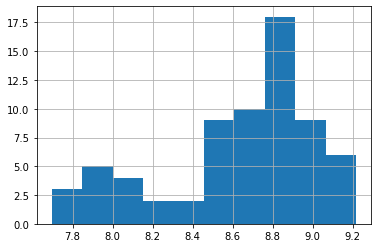

In [43]:
chosen.affinity.hist()

In [44]:
from generation_utils import get_LAS_distance_constraint_mask, get_info_pred_distance, write_with_new_coords
# pick one with affinity greater than 7.
chosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen = chosen.query("affinity > 7").reset_index(drop=True)
line = chosen.iloc[0]
idx = line['index']
one_data = dataset[idx]
data_with_batch_info = next(iter(DataLoader(dataset[idx:idx+1], batch_size=1, 
                         follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=1)))
y_pred, affinity_pred = model(data_with_batch_info)

coords = one_data.coords.to(device)
protein_nodes_xyz = one_data.node_xyz.to(device)
n_compound = coords.shape[0]
n_protein = protein_nodes_xyz.shape[0]
y_pred = y_pred.reshape(n_protein, n_compound).to(device).detach()
y = one_data.dis_map.reshape(n_protein, n_compound).to(device)
compound_pair_dis_constraint = torch.cdist(coords, coords)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)

In [ ]:
smiles = line['smiles']
print(smiles)
mol = Chem.MolFromSmiles(smiles)
mol.Compute2DCoords()
LAS_distance_constraint_mask = get_LAS_distance_constraint_mask(mol).bool()
info = get_info_pred_distance(coords, y_pred, protein_nodes_xyz, compound_pair_dis_constraint, 
                              LAS_distance_constraint_mask=LAS_distance_constraint_mask,
                              n_repeat=1, show_progress=False)
toFile = f'{base_pre}/one_tankbind.sdf'
new_coords = info.sort_values("loss")['coords'].iloc[0].astype(np.double)
write_with_new_coords(mol, new_coords, toFile)

In [ ]:
import nglview   # conda install nglview -c conda-forge if import failure

proteinName = "6dlo"
proteinFile = f"{base_pre}/{proteinName}.pdb"
view = nglview.show_file(nglview.FileStructure(proteinFile), default=False)
view.add_representation('cartoon', selection='protein', color='white')

predictedFile = f'{base_pre}/one_tankbind.sdf'
rdkit = view.add_component(nglview.FileStructure(predictedFile), default=False)
rdkit.add_ball_and_stick(color='red')
view

In [ ]:
view.render_image()

In [ ]:
view._display_image()